In [1]:
import os

# Enable MPS for the Python process
os.environ['TF_MPS'] = '1'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn
from sklearn.metrics import f1_score, classification_report,confusion_matrix
import uuid
from carbontracker.tracker import CarbonTracker
from codecarbon import track_emissions

In [3]:
# Define data directories
data_dir = '../data/'  

In [4]:
# Define the class names
class_names = ['buffalo','eland', 'elephant','giraffe','hyaenabrown','impala','leopard','lion','rhino', 'zebra']

In [5]:
# Define data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2,  # Set aside 20% of the data for testing
)

# Load and preprocess training data
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=64,
    class_mode='categorical',  # or 'binary', depending on your task
    classes=class_names,
    shuffle=True,
    seed=42,
    subset='training',  # Specify that this is the training split
)

# Load and preprocess testing data
test_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    classes=class_names,
    shuffle=False,  # Set to False to keep the order of images
    seed=42,
    subset='validation',  # Specify that this is the testing split
)

Found 56446 images belonging to 10 classes.
Found 14106 images belonging to 10 classes.


In [6]:
# Get class indices
class_indices = train_data.class_indices

# Count the number of images in each class for each split
training_count = {class_name: sum(1 for _ in train_data.classes if _ == class_indices[class_name]) for class_name in class_indices}
testing_count = {class_name: sum(1 for _ in test_data.classes if _ == class_indices[class_name]) for class_name in class_indices}

# Display the counts for each split
print("Training split:")
for class_name, count in training_count.items():
    print(f"Class '{class_name}' has {count} images.")

print("\nTesting split:")
for class_name, count in testing_count.items():
    print(f"Class '{class_name}' has {count} images.")

Training split:
Class 'buffalo' has 2590 images.
Class 'eland' has 2874 images.
Class 'elephant' has 5940 images.
Class 'giraffe' has 4499 images.
Class 'hyaenabrown' has 2400 images.
Class 'impala' has 23615 images.
Class 'leopard' has 921 images.
Class 'lion' has 785 images.
Class 'rhino' has 3258 images.
Class 'zebra' has 9564 images.

Testing split:
Class 'buffalo' has 647 images.
Class 'eland' has 718 images.
Class 'elephant' has 1485 images.
Class 'giraffe' has 1124 images.
Class 'hyaenabrown' has 599 images.
Class 'impala' has 5903 images.
Class 'leopard' has 230 images.
Class 'lion' has 196 images.
Class 'rhino' has 814 images.
Class 'zebra' has 2390 images.


In [7]:
# Create the base model with pre-trained weights (InceptionV3)
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(299, 299, 3),
    pooling='avg',
    classifier_activation='softmax',
)

# Add custom classification layers on top of the base model
x = base_model.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 2

In [8]:
# @track_emissions()
def training(train_data,epochs,validation_data):
    return model.fit(train_data, epochs=num_epochs, validation_data=test_data)

In [9]:
history = training(train_data=train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/2
882/882 [==============================] - 13042s 15s/step - loss: 0.5032 - accuracy: 0.8472 - val_loss: 0.7071 - val_accuracy: 0.8109
Epoch 2/2
882/882 [==============================] - 24351s 28s/step - loss: 0.3203 - accuracy: 0.9033 - val_loss: 1.0974 - val_accuracy: 0.7927


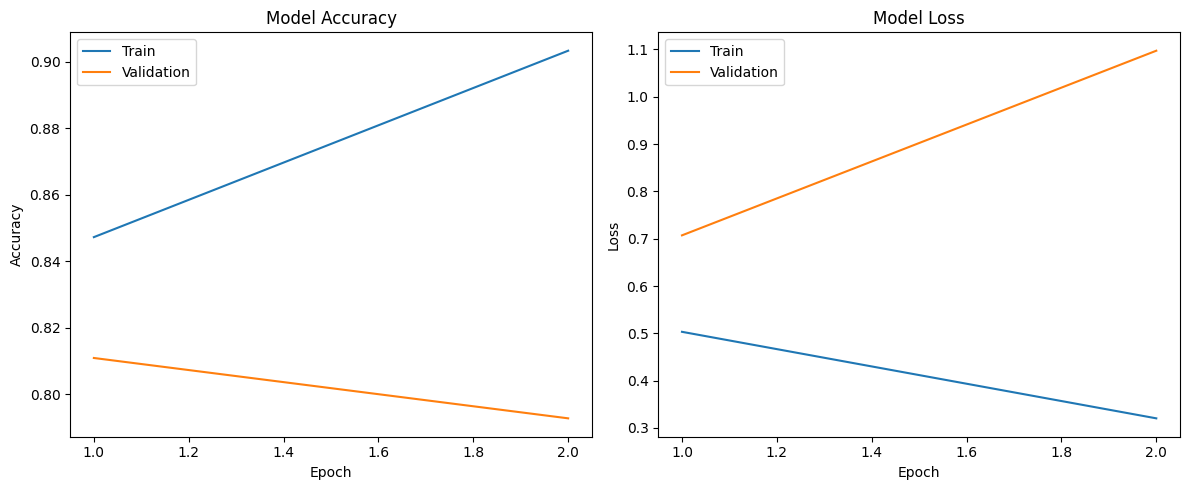

In [10]:
# Get the number of epochs
epochs = len(history.history['accuracy'])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'])
plt.plot(range(1, epochs + 1), history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.plot(range(1, epochs + 1), history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model
test_data.reset()
y_pred = model.predict(test_data, steps=np.ceil(test_data.samples / 64))
y_true = test_data.classes

f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')
print(f"F1 Score : {f1}")

221/221 [==============================] - 622s 3s/step
F1 Score : 0.7794642125568227


In [12]:
print("Classification Report:")
print(classification_report(y_true, np.argmax(y_pred, axis=1)))

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.82      0.50       647
           1       0.87      0.08      0.14       718
           2       0.83      0.52      0.64      1485
           3       0.98      0.84      0.90      1124
           4       0.67      0.78      0.72       599
           5       0.92      0.92      0.92      5903
           6       0.66      0.84      0.74       230
           7       0.29      0.59      0.39       196
           8       0.75      0.37      0.50       814
           9       0.80      0.98      0.88      2390

    accuracy                           0.79     14106
   macro avg       0.71      0.67      0.63     14106
weighted avg       0.83      0.79      0.78     14106



In [13]:
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

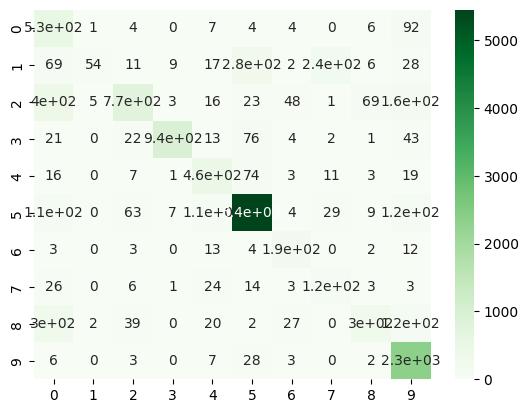

In [14]:
seaborn.heatmap(confusion, cmap='Greens', annot=True)
plt.show()

In [15]:
# Save the model in TensorFlow Lite format
tflite_model_path = '../models/tinyml_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmp1radfoou/assets


INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmp1radfoou/assets
2023-11-25 19:45:47.262585: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-25 19:45:47.262779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


In [16]:
test_dir = '../../dataset/some_data/'

In [17]:
# Initialize lists to store image paths and labels
test_images = []
test_labels = []

# Loop through class names and corresponding directories
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    class_images = os.listdir(class_dir)
    num_images = len(class_images)

    for image_filename in class_images:
        image_path = os.path.join(class_dir, image_filename)
        label = class_names.index(class_name)

        test_images.append(image_path)
        test_labels.append(label)

In [18]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Perform inference on a sample image
sample_image = tf.keras.preprocessing.image.load_img(
    test_images[20], target_size=(299, 299)
)

In [20]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image = np.expand_dims(sample_image, axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], sample_image)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)

In [21]:
predicted_class

9

In [22]:
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class]

print(f"Predicted Class: {predicted_class_name}")


Predicted Class: zebra


In [23]:
#Compare the predicted label to actual label
print(f"Actual Class: {class_names[test_labels[20]]}")

Actual Class: buffalo


In [25]:
 def representative_dataset_gen():
    for i in range(20):
        data_x, data_y = test_data.next()
        for data_xx in data_x:
            data = tf.reshape(data_xx, shape=[-1, 299, 299, 3])
            yield [data]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops =[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.int8
converter.inference_output_type = tf.int8
quantized_model = converter.convert()
open("../models/tinyml_model_quant.tflite", "wb").write(quantized_model)

INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmppyr9zant/assets


INFO:tensorflow:Assets written to: /var/folders/vq/g110rjmd53bg177m6tkp18d00000gn/T/tmppyr9zant/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-25 19:47:13.358507: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-25 19:47:13.358560: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


22557464

In [26]:
interpreter = tf.lite.Interpreter(model_content=quantized_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>
